### CDS NYU
### DS-GA 1007 | Programming for Data Science
### Lab 11
### Date 


# Pandas: Advanced Data Objects (Part 4)

### ▶ Manipulating, analyzing and vizualizing time series with Pandas 

## Section Leaders


Cora Mao  --  ym1596@nyu.edu  -- 

Devarsh Patel --  dp3324@nyu.edu  --


## Resources

* Concise textbook introduction to Pandas: ”Python Data Science Handbook” pp. 33-96, by Jake VanderPlas
    * Also accessible online at https://jakevdp.github.io/PythonDataScienceHandbook

* Pandas's freely acccessible, online, high-quality and concise documentation: https://pandas.pydata.org



## Reference
https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

https://sunjackson.github.io/2019/01/10/741d21a5f7f4368089a7f8a2cb7556c5/


In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

# Working with Time Series

Pandas contain an extensive set of tools for working with dates, times, and time-indexed data.
Date and time data comes in a few flavors, which we will discuss here:

- *Time stamps* reference particular moments in time (e.g., July 4th, 2015 at 7:00am).
- *Time intervals* and *periods* reference a length of time between a particular beginning and end point; for example, the year 2015. Periods usually reference one specific case of time intervals in which each interval is of uniform length and does not overlap (e.g., 24-hour-long periods comprising days).
- *Time deltas* or *durations* reference an exact length of time (e.g., a duration of 22.56 seconds).

## Dates and Times in Python

Python has several available representations of dates, times, deltas, and timespans.
While the time series tools provided by Pandas tend to be the most useful for data science applications, it is helpful to see their relationship to other packages used in Python.

### Native Python dates and times: ``datetime`` and ``dateutil``

Python's basic objects for working with dates and times reside in the built-in ``datetime`` module.
Along with the third-party ``dateutil`` module, you can use it to quickly perform a host of valuable functionalities on dates and times.
For example, you can manually build a date using the ``datetime`` type:

In [2]:
from datetime import datetime
datetime(year=2015, month=7, day=4)

datetime.datetime(2015, 7, 4, 0, 0)

Or, using the ``dateutil`` module, you can parse dates from a variety of string formats:

In [3]:
from dateutil import parser
date = parser.parse("4th of July, 2015")
date

datetime.datetime(2015, 7, 4, 0, 0)

### Typed arrays of times: NumPy's ``datetime64.``

The weaknesses of Python's datetime format inspired the NumPy team to add native time series data types to NumPy.
The ``datetime64`` dtype encodes dates as 64-bit integers, thus allowing compact representation of arrays.
The ``datetime64`` requires a particular input format:

In [4]:
import numpy as np
date = np.array('2015-07-04', dtype=np.datetime64)
date

array('2015-07-04', dtype='datetime64[D]')

Once we have this date formatted, we can perform vectorized operations on it:

In [5]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
      dtype='datetime64[D]')

Here is a minute-based datetime:

In [6]:
np.datetime64('2015-07-04 12:00')

numpy.datetime64('2015-07-04T12:00')

Notice that the time zone is automatically set to the local time on the computer executing the code.

You can force any desired fundamental unit using one of many format codes; for example, here, we'll force a nanosecond-based time:

In [7]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')

numpy.datetime64('2015-07-04T12:59:59.500000000')

### Dates and times in pandas: more example

In [8]:
import pandas as pd
date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

Additionally, we can do NumPy-style vectorized operations directly on this same object:

In [9]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

In the next section, we will take a closer look at manipulating time series data with the tools provided by Pandas.

## Pandas Time Series: Indexing by Time

Where the Pandas time series tools become helpful is when you begin to *index data by timestamps*.
For example, we can construct a ``Series`` object that has time-indexed data:

In [11]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

Now that we have this data in a ``Series``, we can use any of the ``Series`` indexing patterns discussed in previous sections by coercing values into dates.

In [12]:
data['2014-07-04':'2015-07-04']

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

There are additional special date-only indexing operations, such as passing a year to obtain a slice of all data from that year:

In [13]:
data['2015']

2015-07-04    2
2015-08-04    3
dtype: int64

Later, we will see additional examples of the convenience of dates-as-indices.
But first, a closer look at the available time series data structures.

## Pandas Time Series Data Structures

This section will introduce the fundamental Pandas data structures for working with time series data:

- For *time stamps*, Pandas provides the ``Timestamp`` type. As mentioned before, it is essentially a replacement for Python's native ``datetime``, but is based on the more efficient ``numpy.datetime64`` data type. The associated Index structure is ``DatetimeIndex``.
- For *time Periods*, Pandas provides the ``Period`` type. This encodes a fixed-frequency interval based on ``numpy.datetime64``. The associated index structure is ``PeriodIndex``.
- For *time deltas* or *durations*, Pandas provides the ``Timedelta`` type. ``Timedelta`` is a more efficient replacement for Python's native ``datetime.timedelta`` type, and is based on ``numpy.timedelta64``. The associated index structure is ``TimedeltaIndex``.

The most fundamental of these date/time objects are the ``Timestamp`` and ``DatetimeIndex`` objects.

Passing a single date to ``pd.to_datetime()`` yields a ``Timestamp``; passing a series of dates by default yields a ``DatetimeIndex``:

In [14]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015',
                       '2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

Any ``DatetimeIndex`` can be converted to a ``PeriodIndex`` with the ``to_period()`` function with the addition of a frequency code; here we'll use ``'D'`` to indicate daily frequency:

In [17]:
dates.to_period('D')

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]')

A ``TimedeltaIndex`` is created, for example, when a date is subtracted from another:

In [18]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### Regular sequences: ``pd.date_range()``

To make the creation of regular date sequences more convenient, Pandas offers a few functions for this purpose: ``pd.date_range()`` for timestamps, ``pd.period_range()`` for periods, and ``pd.timedelta_range()`` for time deltas.

``pd.date_range()`` accepts a start date, an end date, and an optional frequency code to create a regular sequence of dates.
By default, the frequency is one day:

In [19]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

Alternatively, the date range in pandas can be specified with a start point and a number of periods. 

In [20]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

The spacing can be modified by altering the ``freq`` argument, which defaults to ``D``.
For example, here we will construct a range of hourly timestamps:

In [21]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

To create regular sequences of ``Period`` or ``Timedelta`` values, the very similar ``pd.period_range()`` and ``pd.timedelta_range()`` functions are helpful.
Here are some monthly periods:

In [22]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]')

And a sequence of durations increasing by an hour:

In [23]:
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00', '0 days 04:00:00', '0 days 05:00:00',
                '0 days 06:00:00', '0 days 07:00:00', '0 days 08:00:00',
                '0 days 09:00:00'],
               dtype='timedelta64[ns]', freq='H')

## Resampling, Shifting, and Windowing

Using dates and times as indices to organize and access data intuitively is an essential piece of the Pandas time series tools.

## Example: Open Power System Data (OPSD)

There has been rapidly expanding its renewable energy production in recent years. In this case study, we will analyze Germany's Open Power System Data (OPSD) using daily time series. The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017.

In [29]:
opsd_daily = pd.read_csv('opsd_germany_daily.csv', index_col=0, parse_dates=True)
opsd_daily.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [ ]:
opsd_daily.tail()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131
2017-12-30,1215.44897,721.247,7.467,728.714
2017-12-31,1107.11488,721.176,19.980,741.156


### Visualizing the data

We can gain some insight into the dataset by visualizing it.
Let's start by plotting the raw data:

In [33]:
%matplotlib inline
import seaborn; seaborn.set()

Let’s create a line plot of the full time series of Germany’s daily electricity consumption, using the DataFrame’s plot() method.

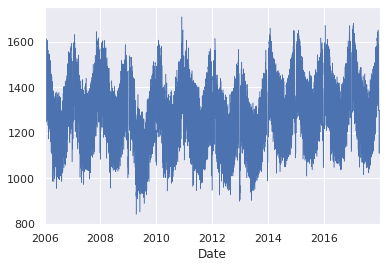

In [34]:
opsd_daily['Consumption'].plot(linewidth=0.5);

### Resampling and converting frequencies

One common need for time series data is Resampling at a higher or lower frequency. For Resampling, we would use the "resample() "method.

We use the DataFrame's resample() method, which splits the DatetimeIndex into time bins and groups the data by time bin. The resample() method returns a Resampler object. We can then apply an aggregation method, such as mean(), median(), sum(), etc., to the data group for each time bin.

For example, let’s resample the data to a weekly mean time series.

In [36]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']
# Resample to weekly frequency, aggregating with mean
opsd_weekly_mean = opsd_daily[data_columns].resample('W').mean()
opsd_weekly_mean.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184000,NaN,NaN,NaN
2006-01-08,1381.300143,NaN,NaN,NaN
2006-01-15,1486.730286,NaN,NaN,NaN


By construction, our weekly time series has 1/7 as many data points as the daily time series. We can confirm this by comparing the number of rows of the two DataFrames.

In [ ]:
print(opsd_daily.shape[0])
print(opsd_weekly_mean.shape[0])

4383
627


### Rolling windows

Rolling statistics are the third type of time series-specific operation implemented by Pandas.
These can be accomplished via the ``rolling()`` attribute of ``Series`` and ``DataFrame`` objects.
This rolling view makes available many aggregation operations by default.


Let’s use the rolling() method to compute the 7-day rolling mean of our daily data. We use the center=True argument to label each window at its midpoint, so the rolling windows are:

2006-01-01 to 2006-01-07 — labelled as 2006-01-04

2006-01-02 to 2006-01-08 — labelled as 2006-01-05

2006-01-03 to 2006-01-09 — labelled as 2006-01-06

And so on.

In [37]:
# Compute the centered 7-day rolling mean
opsd_7d = opsd_daily[data_columns].rolling(7, center=True).mean()
opsd_7d.head(10)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN
2006-01-06,1402.557571,NaN,NaN,NaN
2006-01-07,1421.754429,NaN,NaN,NaN
2006-01-08,1438.891429,NaN,NaN,NaN
2006-01-09,1449.769857,NaN,NaN,NaN


We can see that the first non-missing rolling mean value is on 2006-01-04, because this is the midpoint of the first rolling window.

To visualize the differences between rolling mean and resampling, let’s update our earlier plot of January-June 2017 solar power production to include the 7-day rolling mean along with the weekly mean resampled time series and the original daily data.

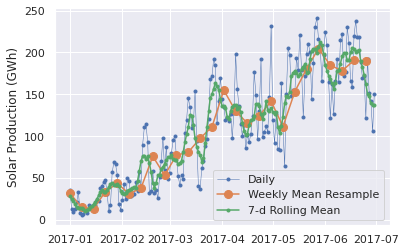

In [ ]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(opsd_7d.loc[start:end, 'Solar'],
marker='.', linestyle='-', label='7-d Rolling Mean')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();